In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from numpy import random

In [16]:
def reward(optim, f, x, M=5, L=-5):
    if optim=='max':
        return (f(x)-L)/(M-L)
    if optim=='min':
        return (-f(x)-L)/(M-L) 
    
def avg_reward(optim, f, action, M=5, L=-5):
    #calculating reward as an average over 10 random picks within the interval (action)
    wtot=0
    for i in range(10):
        x = random.uniform(action[0],action[1])
        if optim=='max':
            wtot += (f(x)-L)/(M-L)
        if optim=='min':
            wtot += (-f(x)-L)/(M-L)
    return wtot/10

def length(action):
    return action[1]-action[0]

def midpoint(action):
    return action[0]+(action[1]-action[0])/2

def normalize(p):
    return [(i-min(p))/(max(p)-min(p)) for i in p]

def remove_interval(actions, l, duplicate=False):
    #remove the lth interval (it is considered as stable and useless for further search)
    del actions[l] 
    if duplicate==True:
        x=int(random.choice(range(len(actions))))
        a,b=actions[x]
        #subdivide a remaining interval into two sub-intervals each corresponding to a new action
        #(the total number of actions is not changed)
        #subdividing the last interval... 
        del actions[x]
        actions.insert(x,(a+(b-a)/2,b))
        actions.insert(x,(a,a+(b-a)/2))
    return actions

def find_peaks_and_valleys(actionsl,dl):
    actionsk=[]
    gamma=[dl[i+1]-dl[i] for i in range(len(dl)-1)]
    threshold=0.1*max(abs(np.array(gamma)))
    for i in range(len(gamma)):
        g=np.sign(gamma[i])
        if abs(gamma[i])>=threshold:
            gprev=g
            left_side=i
            break 
    right_side=len(gamma)
            
    #plt.plot(dl)
    #plt.show()
    #finding peaks:
    end=False
    for i in range(left_side,len(gamma)):
        g=np.sign(gamma[i])
        if i==len(gamma)-1:
            end=True
        elif abs(gamma[i])<threshold:
            continue 

        if g<0 and abs(gamma[i])>=threshold: #downwards
            right_side=i+1

        if g*gprev<0 and g>0 and abs(gamma[i])>=threshold: #sign-switch upwards
            #print("peak between",left_side,"and",right_side)
            actionsk.append((actionsl[left_side][0],actionsl[right_side][1]))
            left_side=i
            right_side=i+1
        if end==True:
            #print("peak between",left_side,"and",right_side)
            actionsk.append((actionsl[left_side][0],actionsl[right_side][1]))

        gprev=g
    
    
    
    return actionsk 

In [17]:
def initialize_actions(a, b, r):
    #(step 2)
    interval=(b-a)/r
    #actions:
    actions=list(zip(np.arange(a,b,interval),np.arange(a+interval,b+interval,interval)))
    return actions
    
def initialize_probs(optim, f, r, actions):
    #(step 3) intialize w,z,d,p with the actions:
    
    #total reward for each action:
    w=[0 for i in range(r)]
    #number of times each action is chosen:
    z=[0 for i in range(r)]
    #initialize w and z by picking each action several times:
    for n in range(10):
        for i in range(r):
            w[i]+=avg_reward(optim, f,actions[i])
            z[i]+=1
    #d=w/z:
    d=[i/j for i,j in zip(w,z)]
    #intialize each p_i as 1/r (probability of chosing action i)
    p=[1/r for i in range(r)]
    return w, z, d, p 
    
def calculate_probs(optim, f, r, actions, w, z, d, p, lamb, delt):
    #(step 4) calculate p and d iteratively until condition is met
    while True:   
        wprev=w.copy()
        zprev=z.copy()
        dprev=d.copy()
        pprev=p.copy()
      
        #pick a random action according to distribution p:
        i_=random.choice(range(r),p=p)
        #update w,z and d:
        w[i_]+=avg_reward(optim, f,actions[i_])
        z[i_]+=1
        d[i_]=w[i_]/z[i_]
        #update p:
        dmax=max(d)
        imax=d.index(dmax)
        p=[(1.-lamb*dmax)*i for i in p]
        p[imax]+=lamb*dmax
        #p=normalize(p) #just to be sure (rounding errors could occur)
        dmin=min(d)
        imin=d.index(dmin)
        if p[imin]<delt:
            break
            
    return wprev, zprev, dprev, pprev, max(dprev), dprev.index(max(dprev)), min(dprev), dprev.index(min(dprev))            

In [20]:
def find_optimum(optim, f, a, b, r, eps, delt, lamb, verb=False):
    """
    optim   boolean: 'min' or 'max': finds minimum or maximum respectively
    f,a,b   function on [a,b]
    r       number of sub-intervals divided
    eps     error band
    delt    threshold of action probabilities (0 < delt < 1/r)
    lamb    speed of convergence (0 < lamb < 1) 
    """
    midpointlist=[]
    #(step 2) initialize actions on the interval
    actions = initialize_actions(a, b, r)
    stop=False
    while True:
        if stop==True:
            break
        if len(actions)==1:
            midpointlist.append(midpoint(actions[0]))
            break
        
        #(step 3) initialize d and p with these actions
        w, z, d, p = initialize_probs(optim, f, r, actions)
        #(step 4) calculate d and p until condition is met
        w, z, d, p, dmax, imax, dmin, imin = calculate_probs(optim, f, r, actions, w, z, d, p, lamb, delt)
        
        if verb==True:
            print("STEP 4")
            xvals=np.linspace(a,b,20)
            plt.plot(xvals,list(map(f,xvals)))
            plt.title("actions (intervals)")
            for _ in actions:
                plt.plot([_[0],_[1]],[0,0])
            plt.show()
            plt.plot(np.linspace(a,b,r), d, marker='*')
            plt.title("reward probabilities d")
            plt.show()
            plt.close()
        
        if max(p)-min(p)==0:
            print("MAX/MIN ERROR")
            break
        
        if verb==True:
            print("STEP 5")
        #(step 5) enhance the search in the lth interval
        l=imin
        #print("l =",l)
        al, bl = actions[l]
        deltl = delt*1.01 #such that 0<delt<deltl<1
        #(step 2) initialize new actions in the lth interval 
        try: actionsl = initialize_actions(al, bl, r)
        except: 
            print("Error: Failed to initialize actions on interval l")
            print(al,bl)
            break
        #(step 3) initialize dl and pl with these actions
        wl, zl, dl, pl = initialize_probs(optim, f, r, actionsl)
        #(step 4) calculate pl and dl
        wl, zl, dl, pl, dlmax, ilmax, dlmin, ilmin = calculate_probs(optim, f, r, actionsl, wl, zl, dl, pl, lamb, deltl)
        #calculate average reward and variance on the lth interval
        Md=np.mean(dl)
        D=max([abs(i-Md) for i in dl])
        if D<eps and dlmin<dmin:
            actions = remove_interval(actions, l, duplicate=True)
            for _, a in enumerate(actions):
                if length(a)<eps:
                    midpointlist.append(midpoint(a))
                    del actions[_]
                    r-=1
                    if len(actions)==0:
                        stop=True
            #print('%s\'th interval removed.'%l)
            #go back to step 4 with updated actions etc.
            continue
        else: 
            #print("STEP 6")
            #(step 6) lth interval is considered as unstable
            #checking the signs of the values to determine the peaks and valleys
            actionsk = find_peaks_and_valleys(actionsl,dl)
            rk=len(actionsk)
            #print(rk,"peaks and valleys found")
            #plt.plot(dl)
            #plt.show()
            #plt.close()
            #print("new intervals are:")
            #for j in actionsk:
            #    print(round(j[0],1),round(j[1],1))
            
            if rk==1:
                alm=actionsl[ilmax]
                actions[l]=alm
            else:
                #repeat steps 3 and 4 for calculating p and d
                wk, zk, dk, pk = initialize_probs(optim, f, rk, actionsk)
                wk, zk, dk, pk, dkmax, ikmax, dkmin, ikmin = calculate_probs(optim, f, rk, actionsk, wk, zk, dk, pk, lamb, delt)
                alm=actionsk[ikmax] #action corresponding to the largest d
                #replace the lth interval by the subinterval of alm:
                actions[l]=alm

            if length(alm)<eps:
                #(step 7) adding the midpoint of the lth interval to a list and remove this interval
                mp=midpoint(alm)
                midpointlist.append(mp)
                #print("STEP 7")
                #print("len(actions)=",len(actions))
                actions = remove_interval(actions, l, duplicate=False)
                r-=1
                #print('%s\'th interval removed.'%l)
                #if the number of remaining intervals is zero, then select the global optimum from the list and stop
                if len(actions)==0:
                    stop=True
                    continue
                else: 
                    continue     
            else: 
                #go back to step 4 with updated actions etc.
                continue

    
    d=[reward(optim,f,i) for i in midpointlist]
    imax=d.index(max(d))
    return midpointlist[imax]
    

In [32]:
f    = lambda x: (np.cos(x/4)*(np.cos(3*x)+np.sin(6*x)))
a    = -2
b    = 2
r    = 20
eps  = 0.05
delt = 0.01
lamb = 0.4
optim = 'max'

maximum=find_optimum(optim, f, a, b, r, eps, delt, lamb)

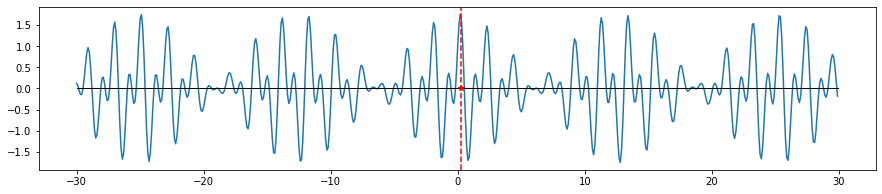

In [33]:
xvals=np.arange(-30,30,0.1)
plt.figure(figsize=(15,3))
plt.plot(xvals,list(map(f,xvals)))
plt.plot(xvals, np.zeros(xvals.shape),color='black',linewidth=1)
plt.plot(maximum,0,'.',marker="*",color='red')
plt.axvline(x=maximum,ls='--',color='red')

plt.show()